# Ownership Map Analysis: Comprehensive Data Exploration

## Overview
This notebook provides an **insanely detailed analysis** of the Ownership_Map.csv dataset, which contains hierarchical ownership structure data for Warner Bros Discovery Inc (WBD US EQUITY). The analysis examines institutional ownership, portfolio distributions, geographic patterns, and ownership concentration.

## Research Questions
1. **Ownership Concentration**: Who are the largest shareholders and how concentrated is ownership?
2. **Institutional Analysis**: What types of institutions hold the most shares?
3. **Geographic Distribution**: Where are the major shareholders located?
4. **Portfolio Analysis**: How do different portfolios allocate to WBD?
5. **Ownership Changes**: What are the recent changes in ownership positions?
6. **Hierarchical Structure**: How is ownership structured across parent-subsidiary relationships?
7. **ETF vs Mutual Fund**: What's the distribution between ETFs and mutual funds?
8. **Insider vs Institutional**: What's the breakdown of insider vs non-insider holdings?

## Dataset Structure
- **Holder Name**: Name of the shareholder (hierarchical structure)
- **Portfolio Name**: Specific portfolio or fund name
- **Position**: Number of shares held
- **Latest Chg**: Recent change in position
- **Filing Date**: Date of the filing
- **Source**: Type of filing (13F, ETF, MF-USA, etc.)
- **% Out**: Percentage of outstanding shares
- **% Portfolio**: Percentage of the portfolio allocated to WBD
- **Insider Status**: Whether the holder is an insider
- **Institution Type**: Type of institution
- **Metro Area**: Geographic location
- **Country**: Country of the institution
- **Tree Level**: Hierarchical level in the ownership tree

In [15]:
# Import all necessary libraries for comprehensive analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import re
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.4.0


In [16]:
# Load and parse the dataset
# The file uses semicolons as separators and has header rows
print("=" * 80)
print("LOADING OWNERSHIP DATA")
print("=" * 80)

# Read the CSV with semicolon separator
df_raw = pd.read_csv('../data/Ownership_Map.csv', sep=';', skiprows=12, encoding='utf-8')

# The first row after skiprows should be the column headers
# Let's check the structure
print(f"\nInitial shape: {df_raw.shape}")
print(f"\nFirst few rows:")
print(df_raw.head())

# Clean column names (remove extra spaces and special characters)
df_raw.columns = df_raw.columns.str.strip()

print(f"\nColumn names:")
print(list(df_raw.columns))


LOADING OWNERSHIP DATA

Initial shape: (4404, 32)

First few rows:
   Unnamed: 0 Holder Name                               Unnamed: 2  \
0           1           -                   Vanguard Group Inc/The   
1           2           -                   Vanguard Group Inc/The   
2           3           -                 Vanguard Group Inc/Wayne   
3           4         NaN                 Vanguard Group Inc/Wayne   
4           5         NaN                 Vanguard Group Inc/Wayne   

   Unnamed: 3  Unnamed: 4                          Portfolio Name  Unnamed: 6  \
0         NaN         NaN                                      --         NaN   
1         NaN         NaN                     Multiple Portfolios         NaN   
2         NaN         NaN                     Multiple Portfolios         NaN   
3         NaN         NaN  Vanguard Total Stock Market Index Fund         NaN   
4         NaN         NaN             Vanguard Mid-Cap Index Fund         NaN   

   Unnamed: 7  Unnamed: 8

In [17]:
# Data cleaning and preprocessing
print("=" * 80)
print("DATA CLEANING & PREPROCESSING")
print("=" * 80)

# Create a clean dataframe
df = df_raw.copy()

# Remove rows that are completely empty or are just separators
df = df.dropna(how='all')
df = df[~df.iloc[:, 0].astype(str).str.contains('^;+$', regex=True, na=False)]

# Clean up the Holder Name column - remove leading/trailing spaces and dashes
if 'Holder Name' in df.columns:
    df['Holder Name'] = df['Holder Name'].astype(str).str.strip()
    # Remove rows where Holder Name is just dashes or empty
    df = df[~df['Holder Name'].isin(['-', 'nan', '', '--'])]

# Convert Position column to numeric (handle European number format with dots as thousands separator)
if 'Position' in df.columns:
    df['Position'] = df['Position'].astype(str).str.replace('.', '', regex=False)
    df['Position'] = df['Position'].str.replace(',', '.', regex=False)  # Convert comma to dot for decimal
    df['Position'] = pd.to_numeric(df['Position'], errors='coerce')

# Convert Latest Chg to numeric
if 'Latest Chg' in df.columns:
    df['Latest Chg'] = df['Latest Chg'].astype(str).str.replace('.', '', regex=False)
    df['Latest Chg'] = df['Latest Chg'].str.replace(',', '.', regex=False)
    df['Latest Chg'] = pd.to_numeric(df['Latest Chg'], errors='coerce')

# Convert percentage columns
for col in ['% Out', '% Portfolio']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert Filing Date to datetime
if 'Filing Date' in df.columns:
    df['Filing Date'] = pd.to_datetime(df['Filing Date'], format='%d.%m.%Y', errors='coerce')

# Clean text columns
text_cols = ['Portfolio Name', 'Source', 'Insider Status', 'Institution Type', 'Metro Area', 'Country']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].replace(['nan', 'N/A', '--', '-'], np.nan)

# Convert Tree Level to numeric
if 'Tree Level' in df.columns:
    df['Tree Level'] = pd.to_numeric(df['Tree Level'], errors='coerce')

print(f"\nCleaned dataset shape: {df.shape}")
print(f"Rows with valid Position data: {df['Position'].notna().sum()}")
print(f"Rows with valid Holder Name: {df['Holder Name'].notna().sum()}")
print(f"\nData types:")
print(df.dtypes)


DATA CLEANING & PREPROCESSING

Cleaned dataset shape: (0, 32)
Rows with valid Position data: 0
Rows with valid Holder Name: 0

Data types:
Unnamed: 0                   int64
Holder Name                 object
Unnamed: 2                  object
Unnamed: 3                 float64
Unnamed: 4                 float64
Portfolio Name              object
Unnamed: 6                 float64
Unnamed: 7                 float64
Unnamed: 8                 float64
Unnamed: 9                 float64
Position                     int64
Latest Chg                   int64
Filing Date         datetime64[ns]
Source                      object
% Out                        int64
% Portfolio                  int64
Insider Status              object
Institution Type            object
Metro Area                  object
Country                     object
Market Value               float64
Hold Period                float64
Cost (FIFO)                float64
Cost (LIFO)                float64
Cost (Avg.)          

In [18]:
# Initial data inspection
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"\nFirst few rows with data:")
print(df.head(10))

# Check for missing values
print("\n" + "=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

# Basic statistics
print("\n" + "=" * 80)
print("BASIC STATISTICS")
print("=" * 80)
print(f"Unique holders: {df['Holder Name'].nunique()}")
print(f"Unique portfolios: {df['Portfolio Name'].nunique()}")
print(f"Unique countries: {df['Country'].nunique()}")
print(f"Unique institution types: {df['Institution Type'].nunique()}")
print(f"Unique sources: {df['Source'].nunique()}")
print(f"Date range: {df['Filing Date'].min()} to {df['Filing Date'].max()}")

# Position statistics
if df['Position'].notna().any():
    print(f"\nPosition Statistics:")
    print(f"  Total shares: {df['Position'].sum():,.0f}")
    print(f"  Mean position: {df['Position'].mean():,.0f}")
    print(f"  Median position: {df['Position'].median():,.0f}")
    print(f"  Max position: {df['Position'].max():,.0f}")
    print(f"  Min position: {df['Position'].min():,.0f}")


DATASET OVERVIEW
Total rows: 0
Total columns: 32

First few rows with data:
Empty DataFrame
Columns: [Unnamed: 0, Holder Name, Unnamed: 2, Unnamed: 3, Unnamed: 4, Portfolio Name, Unnamed: 6, Unnamed: 7, Unnamed: 8, Unnamed: 9, Position, Latest Chg, Filing Date, Source, % Out, % Portfolio, Insider Status, Institution Type, Metro Area, Country, Market Value, Hold Period, Cost (FIFO), Cost (LIFO), Cost (Avg.), Ret % (FIFO), Ret % (LIFO), Ret % (Avg), Unnamed: 28, Expand Num, Already Expand, Tree Level]
Index: []

MISSING VALUES ANALYSIS
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []

BASIC STATISTICS
Unique holders: 0
Unique portfolios: 0
Unique countries: 0
Unique institution types: 0
Unique sources: 0
Date range: NaT to NaT


## Section 1: Top Shareholders Analysis

**Question**: Who are the largest shareholders? How concentrated is ownership?

**Key Insights to Discover**:
- Top 20 shareholders by position size
- Ownership concentration metrics
- Cumulative ownership distribution
- Largest individual positions


TOP SHAREHOLDERS ANALYSIS

Top 20 Shareholders by Position:
Empty DataFrame
Columns: [Position, % Out, Latest Chg]
Index: []


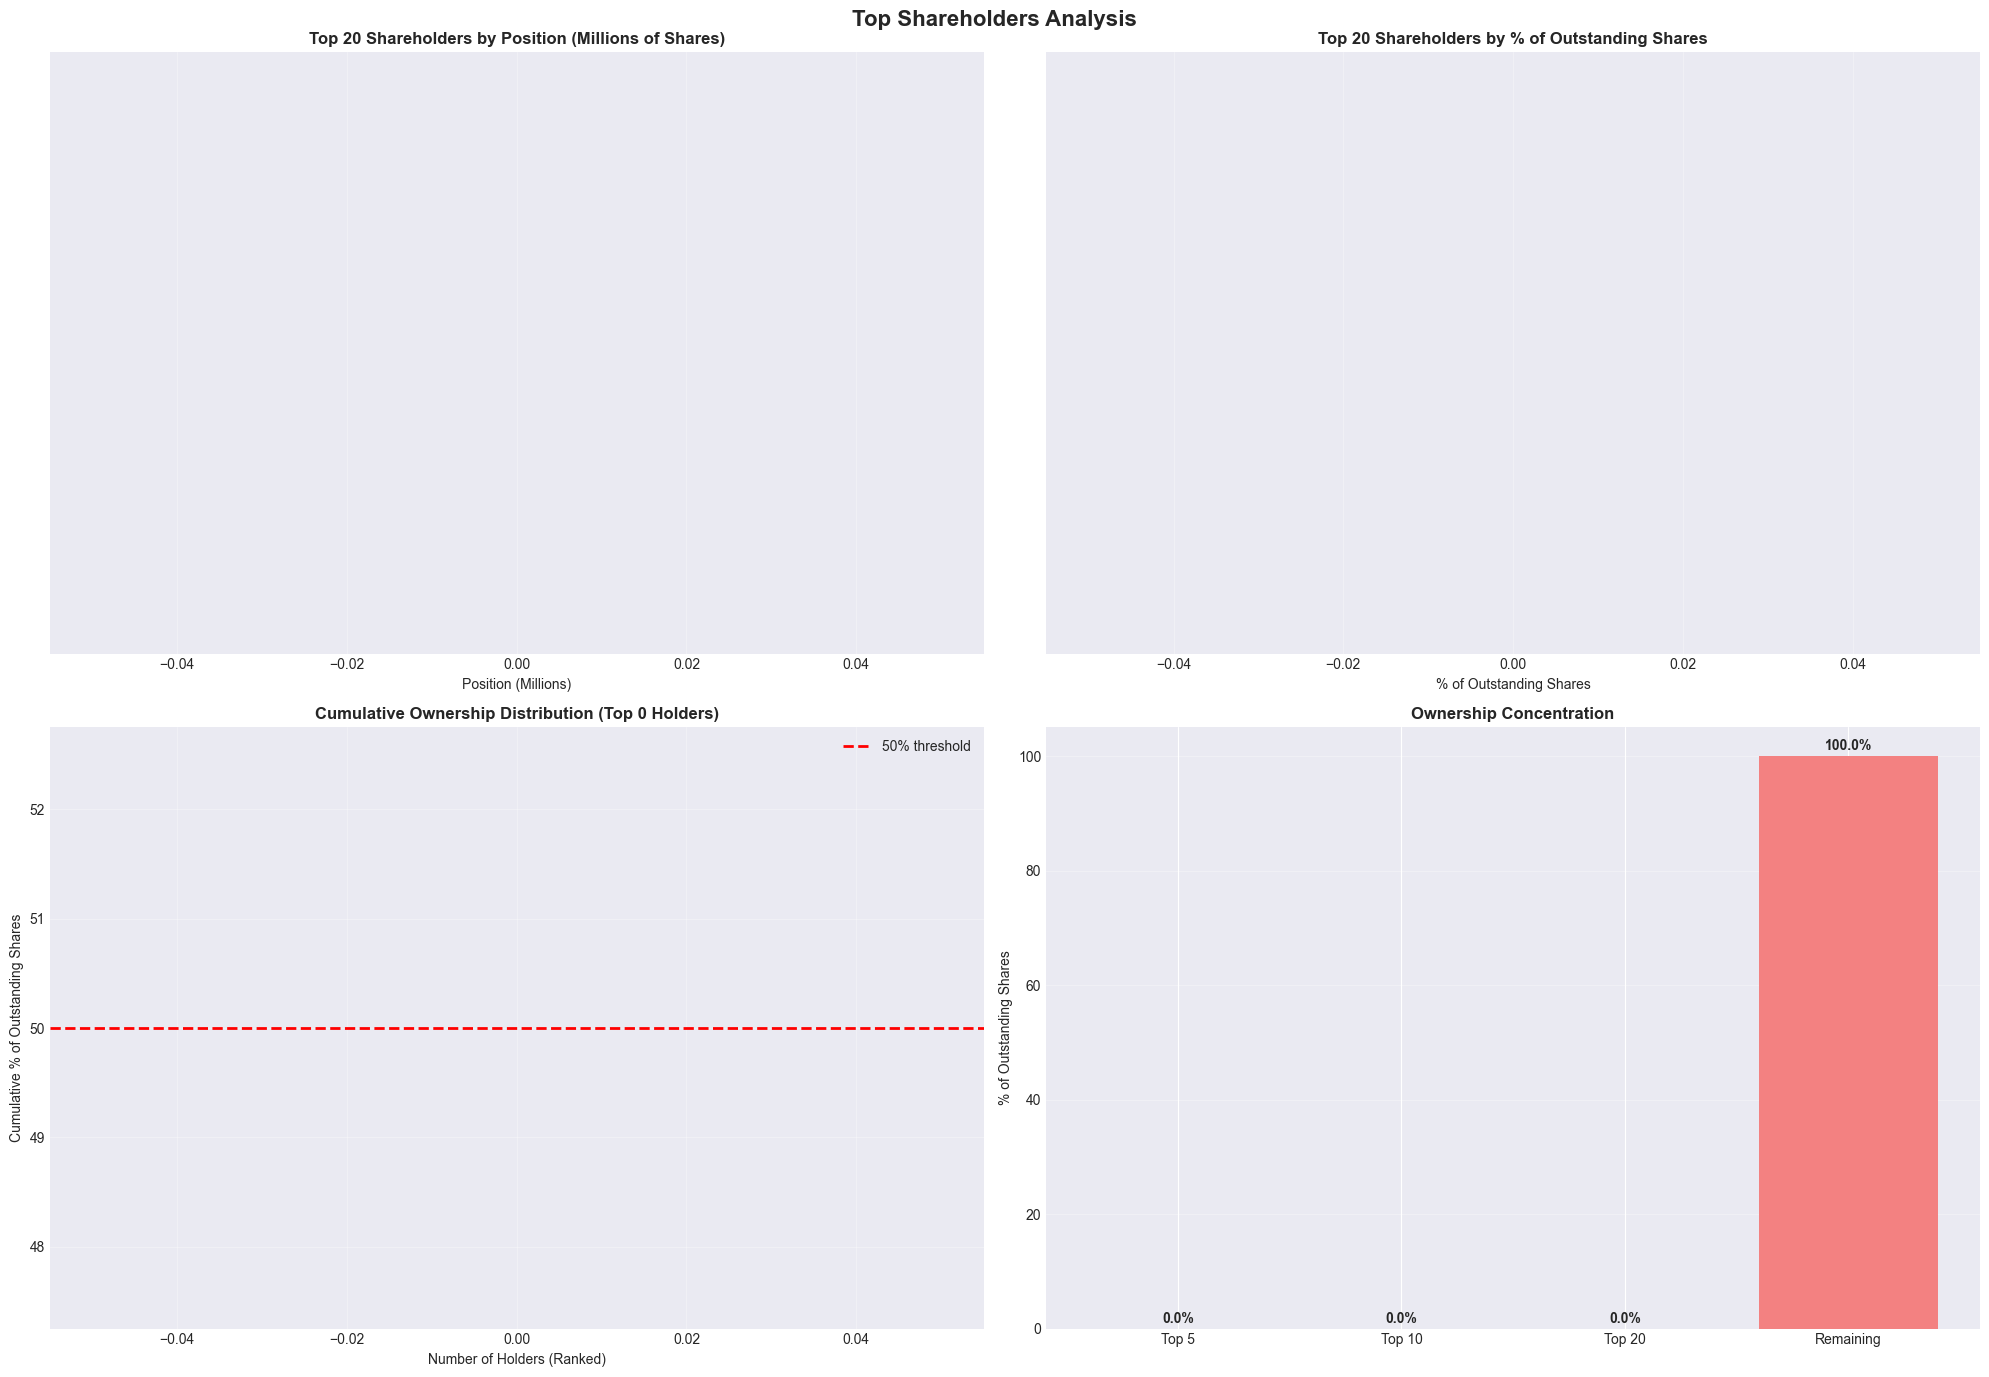


OWNERSHIP CONCENTRATION SUMMARY
Top 5 holders control: 0.00% of outstanding shares
Top 10 holders control: 0.00% of outstanding shares
Top 20 holders control: 0.00% of outstanding shares
Largest single holder: N/A (no data available)


In [21]:
# Top Shareholders Analysis
print("=" * 80)
print("TOP SHAREHOLDERS ANALYSIS")
print("=" * 80)

# Filter to top-level holders (Tree Level 0 or 1) for main analysis
top_level_holders = df[df['Tree Level'] <= 1].copy()

# Aggregate by Holder Name for top holders
holder_totals = top_level_holders.groupby('Holder Name').agg({
    'Position': 'sum',
    '% Out': 'sum',
    'Latest Chg': 'sum'
}).sort_values('Position', ascending=False)

print(f"\nTop 20 Shareholders by Position:")
print(holder_totals.head(20))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Top Shareholders Analysis', fontsize=16, fontweight='bold')

# 1. Top 20 Holders by Position
top_20 = holder_totals.head(20)
axes[0, 0].barh(range(len(top_20)), top_20['Position'].values / 1e6, 
                color=sns.color_palette("viridis", len(top_20)))
axes[0, 0].set_yticks(range(len(top_20)))
axes[0, 0].set_yticklabels(top_20.index, fontsize=9)
axes[0, 0].set_title('Top 20 Shareholders by Position (Millions of Shares)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Position (Millions)')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_20['Position'].values / 1e6):
    axes[0, 0].text(v + 1, i, f'{v:.1f}M', va='center', fontweight='bold', fontsize=8)

# 2. Top 20 Holders by % Out
top_20_pct = holder_totals.head(20).sort_values('% Out', ascending=True)
axes[0, 1].barh(range(len(top_20_pct)), top_20_pct['% Out'].values,
                color=sns.color_palette("plasma", len(top_20_pct)))
axes[0, 1].set_yticks(range(len(top_20_pct)))
axes[0, 1].set_yticklabels(top_20_pct.index, fontsize=9)
axes[0, 1].set_title('Top 20 Shareholders by % of Outstanding Shares', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('% of Outstanding Shares')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_20_pct['% Out'].values):
    axes[0, 1].text(v + 0.1, i, f'{v:.2f}%', va='center', fontweight='bold', fontsize=8)

# 3. Cumulative Ownership Distribution
sorted_holders = holder_totals.sort_values('Position', ascending=False)
cumulative_pct = sorted_holders['% Out'].cumsum()
top_n = min(50, len(cumulative_pct))
axes[1, 0].plot(range(1, top_n + 1), cumulative_pct.head(top_n).values, 
               marker='o', linewidth=2, markersize=4, color='steelblue')
axes[1, 0].axhline(y=50, color='r', linestyle='--', linewidth=2, label='50% threshold')
axes[1, 0].set_title(f'Cumulative Ownership Distribution (Top {top_n} Holders)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Holders (Ranked)')
axes[1, 0].set_ylabel('Cumulative % of Outstanding Shares')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Ownership Concentration: Top 5, 10, 20 Share
top5_share = sorted_holders.head(5)['% Out'].sum()
top10_share = sorted_holders.head(10)['% Out'].sum()
top20_share = sorted_holders.head(20)['% Out'].sum()
remaining_share = 100 - sorted_holders['% Out'].sum()

concentration_data = {
    'Top 5': top5_share,
    'Top 10': top10_share,
    'Top 20': top20_share,
    'Remaining': remaining_share
}

axes[1, 1].bar(concentration_data.keys(), concentration_data.values(),
               color=['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181'])
axes[1, 1].set_title('Ownership Concentration', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('% of Outstanding Shares')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for k, v in concentration_data.items():
    axes[1, 1].text(k, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n" + "=" * 80)
print("OWNERSHIP CONCENTRATION SUMMARY")
print("=" * 80)
print(f"Top 5 holders control: {top5_share:.2f}% of outstanding shares")
print(f"Top 10 holders control: {top10_share:.2f}% of outstanding shares")
print(f"Top 20 holders control: {top20_share:.2f}% of outstanding shares")
if not sorted_holders.empty:
    print(f"Largest single holder: {sorted_holders.index[0]} ({sorted_holders.iloc[0]['% Out']:.2f}%)")
else:
    print("Largest single holder: N/A (no data available)")


INSTITUTIONAL TYPE ANALYSIS

Institution Type Statistics:
Empty DataFrame
Columns: [Total_Position, Avg_Position, Count, Total_%_Out, Unique_Holders]
Index: []


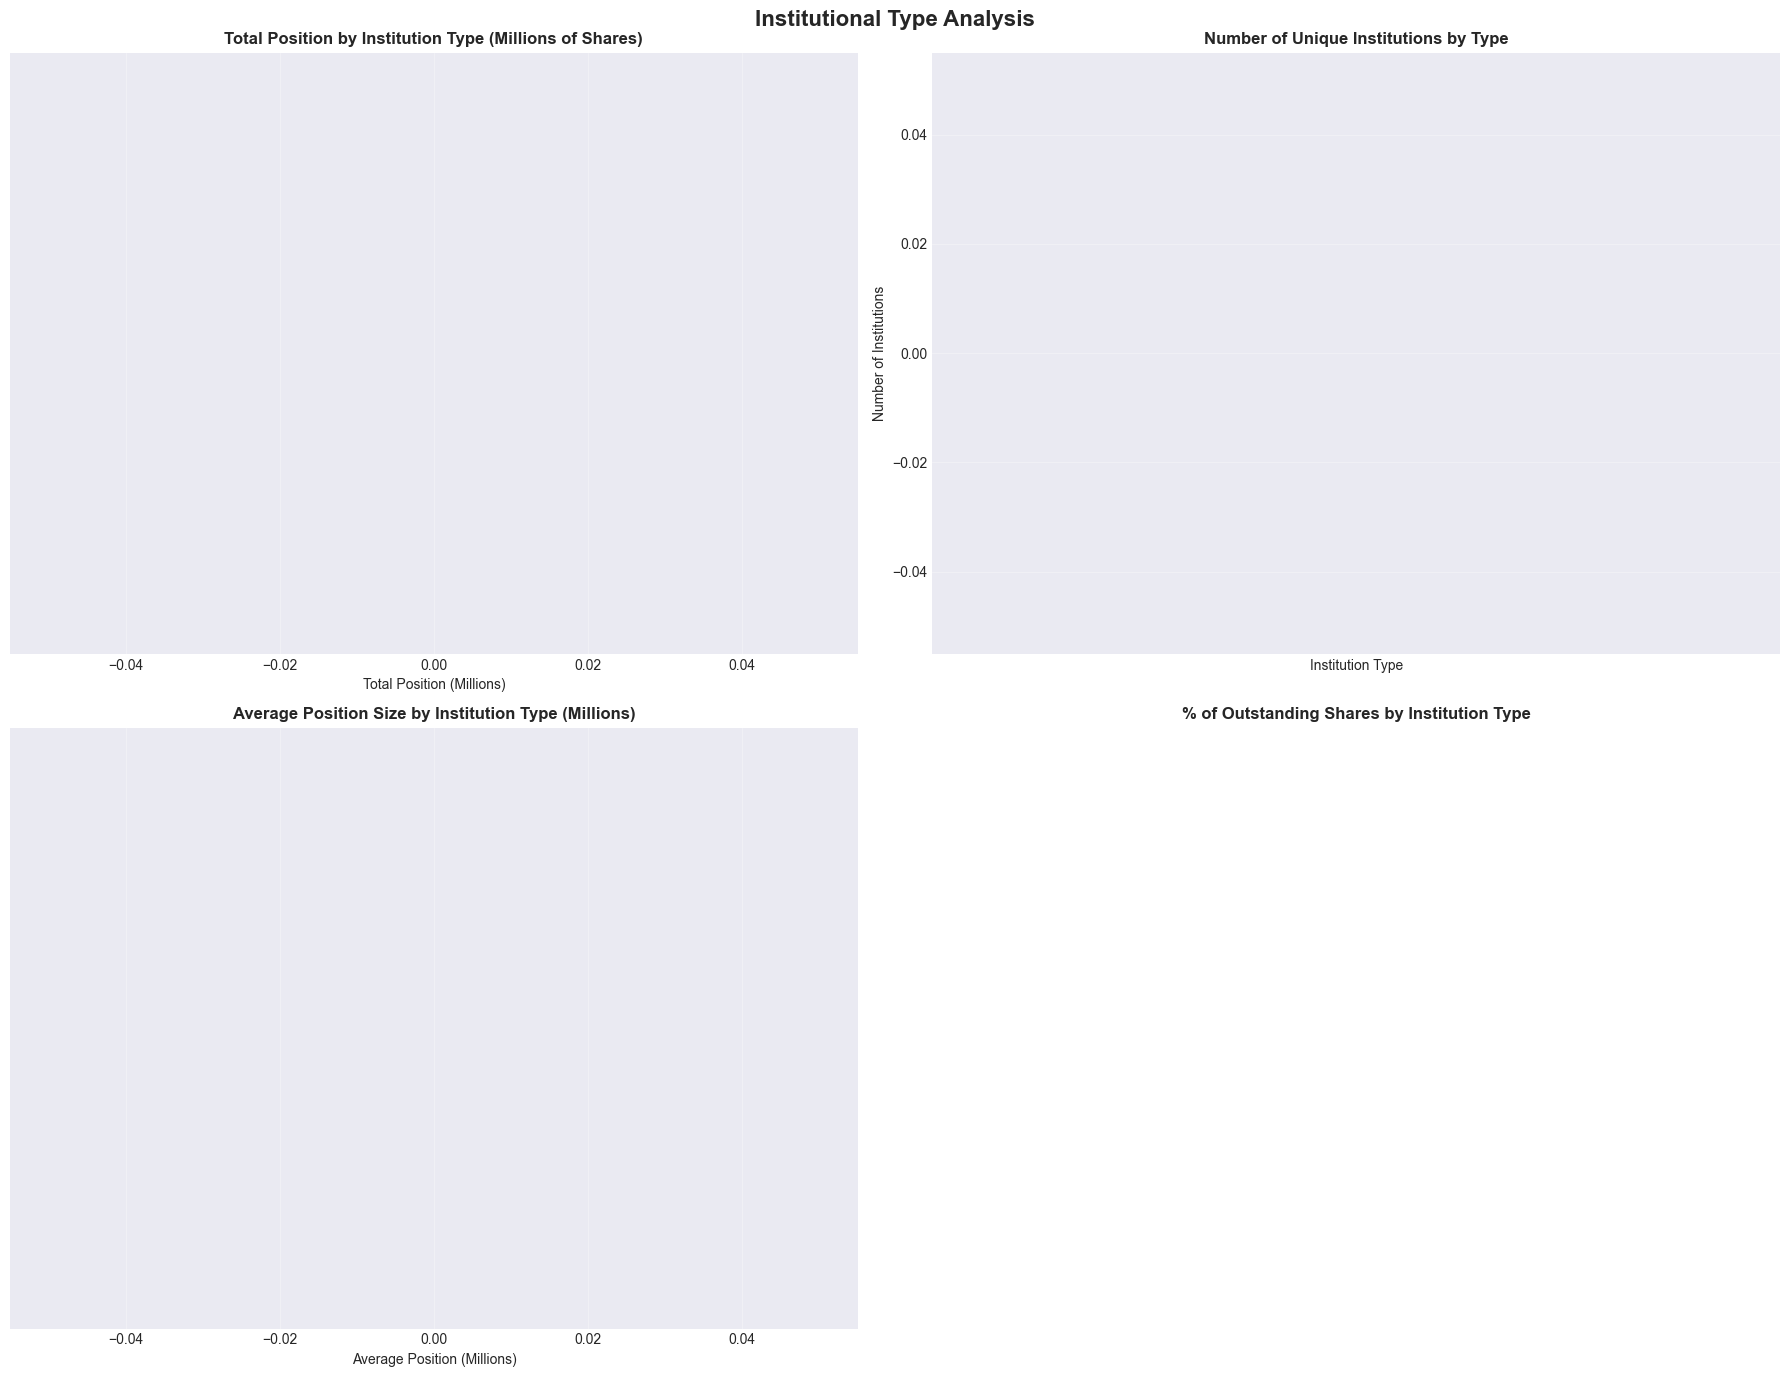


INSTITUTION TYPE SUMMARY


IndexError: index 0 is out of bounds for axis 0 with size 0

In [22]:
# Institutional Type Analysis
print("=" * 80)
print("INSTITUTIONAL TYPE ANALYSIS")
print("=" * 80)

# Filter to valid data
inst_data = df[df['Institution Type'].notna() & df['Position'].notna()].copy()

# Aggregate by Institution Type
inst_type_stats = inst_data.groupby('Institution Type').agg({
    'Position': ['sum', 'mean', 'count'],
    '% Out': 'sum',
    'Holder Name': 'nunique'
}).round(2)

inst_type_stats.columns = ['Total_Position', 'Avg_Position', 'Count', 'Total_%_Out', 'Unique_Holders']
inst_type_stats = inst_type_stats.sort_values('Total_Position', ascending=False)

print("\nInstitution Type Statistics:")
print(inst_type_stats)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Institutional Type Analysis', fontsize=16, fontweight='bold')

# 1. Total Position by Institution Type
axes[0, 0].barh(range(len(inst_type_stats)), inst_type_stats['Total_Position'].values / 1e6,
                color=sns.color_palette("Set2", len(inst_type_stats)))
axes[0, 0].set_yticks(range(len(inst_type_stats)))
axes[0, 0].set_yticklabels(inst_type_stats.index, fontsize=10)
axes[0, 0].set_title('Total Position by Institution Type (Millions of Shares)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Total Position (Millions)')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(inst_type_stats['Total_Position'].values / 1e6):
    axes[0, 0].text(v + 1, i, f'{v:.1f}M', va='center', fontweight='bold', fontsize=9)

# 2. Number of Institutions by Type
axes[0, 1].bar(range(len(inst_type_stats)), inst_type_stats['Unique_Holders'].values,
               color=sns.color_palette("husl", len(inst_type_stats)))
axes[0, 1].set_title('Number of Unique Institutions by Type', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Institution Type')
axes[0, 1].set_ylabel('Number of Institutions')
axes[0, 1].set_xticks(range(len(inst_type_stats)))
axes[0, 1].set_xticklabels(inst_type_stats.index, rotation=45, ha='right', fontsize=9)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(inst_type_stats['Unique_Holders'].values):
    axes[0, 1].text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold', fontsize=9)

# 3. Average Position Size by Institution Type
axes[1, 0].barh(range(len(inst_type_stats)), inst_type_stats['Avg_Position'].values / 1e6,
                color=sns.color_palette("coolwarm", len(inst_type_stats)))
axes[1, 0].set_yticks(range(len(inst_type_stats)))
axes[1, 0].set_yticklabels(inst_type_stats.index, fontsize=10)
axes[1, 0].set_title('Average Position Size by Institution Type (Millions)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Average Position (Millions)')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(inst_type_stats['Avg_Position'].values / 1e6):
    axes[1, 0].text(v + 0.5, i, f'{v:.2f}M', va='center', fontweight='bold', fontsize=9)

# 4. % of Outstanding Shares by Institution Type
axes[1, 1].pie(inst_type_stats['Total_%_Out'].values, labels=inst_type_stats.index, 
               autopct='%1.1f%%', startangle=90,
               colors=sns.color_palette("Set3", len(inst_type_stats)))
axes[1, 1].set_title('% of Outstanding Shares by Institution Type', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print(f"\n" + "=" * 80)
print("INSTITUTION TYPE SUMMARY")
print("=" * 80)
print(f"Dominant institution type: {inst_type_stats.index[0]}")
print(f"  Total position: {inst_type_stats.iloc[0]['Total_Position']:,.0f} shares")
print(f"  % of outstanding: {inst_type_stats.iloc[0]['Total_%_Out']:.2f}%")
print(f"  Number of institutions: {inst_type_stats.iloc[0]['Unique_Holders']:.0f}")


In [ ]:
# Geographic Distribution Analysis
print("=" * 80)
print("GEOGRAPHIC DISTRIBUTION ANALYSIS")
print("=" * 80)

# Filter to valid geographic data
geo_data = df[df['Country'].notna() & df['Position'].notna()].copy()

# Aggregate by Country
country_stats = geo_data.groupby('Country').agg({
    'Position': ['sum', 'mean', 'count'],
    '% Out': 'sum',
    'Holder Name': 'nunique'
}).round(2)

country_stats.columns = ['Total_Position', 'Avg_Position', 'Count', 'Total_%_Out', 'Unique_Holders']
country_stats = country_stats.sort_values('Total_Position', ascending=False)

print("\nCountry Statistics:")
print(country_stats.head(15))

# Metro Area Analysis (Top 20)
metro_stats = geo_data[geo_data['Metro Area'].notna()].groupby('Metro Area').agg({
    'Position': 'sum',
    '% Out': 'sum',
    'Holder Name': 'nunique'
}).sort_values('Position', ascending=False).head(20)

print(f"\nTop 20 Metro Areas:")
print(metro_stats)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Geographic Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Total Position by Country (Top 15)
top_countries = country_stats.head(15)
axes[0, 0].barh(range(len(top_countries)), top_countries['Total_Position'].values / 1e6,
                color=sns.color_palette("viridis", len(top_countries)))
axes[0, 0].set_yticks(range(len(top_countries)))
axes[0, 0].set_yticklabels(top_countries.index, fontsize=10)
axes[0, 0].set_title('Total Position by Country (Top 15, Millions)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Total Position (Millions)')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_countries['Total_Position'].values / 1e6):
    axes[0, 0].text(v + 1, i, f'{v:.1f}M', va='center', fontweight='bold', fontsize=9)

# 2. % of Outstanding by Country
top_countries_pct = country_stats.head(15).sort_values('Total_%_Out', ascending=True)
axes[0, 1].barh(range(len(top_countries_pct)), top_countries_pct['Total_%_Out'].values,
                color=sns.color_palette("plasma", len(top_countries_pct)))
axes[0, 1].set_yticks(range(len(top_countries_pct)))
axes[0, 1].set_yticklabels(top_countries_pct.index, fontsize=10)
axes[0, 1].set_title('% of Outstanding Shares by Country (Top 15)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('% of Outstanding Shares')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_countries_pct['Total_%_Out'].values):
    axes[0, 1].text(v + 0.1, i, f'{v:.2f}%', va='center', fontweight='bold', fontsize=9)

# 3. Number of Institutions by Country
axes[1, 0].bar(range(len(top_countries)), top_countries['Unique_Holders'].values,
               color=sns.color_palette("Set2", len(top_countries)))
axes[1, 0].set_title('Number of Unique Institutions by Country (Top 15)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Country')
axes[1, 0].set_ylabel('Number of Institutions')
axes[1, 0].set_xticks(range(len(top_countries)))
axes[1, 0].set_xticklabels(top_countries.index, rotation=45, ha='right', fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(top_countries['Unique_Holders'].values):
    axes[1, 0].text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold', fontsize=9)

# 4. Top 15 Metro Areas
axes[1, 1].barh(range(len(metro_stats.head(15))), metro_stats.head(15)['Position'].values / 1e6,
                color=sns.color_palette("mako", len(metro_stats.head(15))))
axes[1, 1].set_yticks(range(len(metro_stats.head(15))))
axes[1, 1].set_yticklabels(metro_stats.head(15).index, fontsize=9)
axes[1, 1].set_title('Top 15 Metro Areas by Position (Millions)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Total Position (Millions)')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(metro_stats.head(15)['Position'].values / 1e6):
    axes[1, 1].text(v + 0.5, i, f'{v:.1f}M', va='center', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

# Summary
print(f"\n" + "=" * 80)
print("GEOGRAPHIC DISTRIBUTION SUMMARY")
print("=" * 80)
print(f"Total countries represented: {country_stats.shape[0]}")
print(f"Dominant country: {country_stats.index[0]}")
print(f"  Total position: {country_stats.iloc[0]['Total_Position']:,.0f} shares")
print(f"  % of outstanding: {country_stats.iloc[0]['Total_%_Out']:.2f}%")
print(f"  Number of institutions: {country_stats.iloc[0]['Unique_Holders']:.0f}")
print(f"\nTop 3 countries control: {country_stats.head(3)['Total_%_Out'].sum():.2f}% of outstanding shares")


## Section 4: Source Type Analysis (ETF vs Mutual Fund vs Others)

**Question**: How is ownership distributed across different source types (ETFs, Mutual Funds, 13F filings, etc.)?

**Key Insights to Discover**:
- Distribution by source type
- ETF vs Mutual Fund comparison
- Position sizes by source
- Filing type patterns


In [ ]:
# Source Type Analysis
print("=" * 80)
print("SOURCE TYPE ANALYSIS")
print("=" * 80)

# Filter to valid source data
source_data = df[df['Source'].notna() & df['Position'].notna()].copy()

# Categorize sources into broader groups
def categorize_source(source):
    source_str = str(source).upper()
    if 'ETF' in source_str:
        return 'ETF'
    elif 'MF-' in source_str or 'MUTUAL FUND' in source_str:
        return 'Mutual Fund'
    elif '13F' in source_str:
        return '13F Filing'
    elif '13G' in source_str:
        return '13G Filing'
    elif 'AGG' in source_str:
        return 'Aggregated'
    else:
        return 'Other'

source_data['Source_Category'] = source_data['Source'].apply(categorize_source)

# Aggregate by Source Category
source_stats = source_data.groupby('Source_Category').agg({
    'Position': ['sum', 'mean', 'count'],
    '% Out': 'sum',
    'Holder Name': 'nunique',
    'Portfolio Name': 'nunique'
}).round(2)

source_stats.columns = ['Total_Position', 'Avg_Position', 'Count', 'Total_%_Out', 'Unique_Holders', 'Unique_Portfolios']
source_stats = source_stats.sort_values('Total_Position', ascending=False)

print("\nSource Category Statistics:")
print(source_stats)

# Detailed Source Analysis
source_detailed = source_data.groupby('Source').agg({
    'Position': 'sum',
    '% Out': 'sum',
    'Holder Name': 'nunique'
}).sort_values('Position', ascending=False).head(20)

print(f"\nTop 20 Individual Sources:")
print(source_detailed)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Source Type Analysis', fontsize=16, fontweight='bold')

# 1. Total Position by Source Category
axes[0, 0].barh(range(len(source_stats)), source_stats['Total_Position'].values / 1e6,
                color=sns.color_palette("Set2", len(source_stats)))
axes[0, 0].set_yticks(range(len(source_stats)))
axes[0, 0].set_yticklabels(source_stats.index, fontsize=11)
axes[0, 0].set_title('Total Position by Source Category (Millions)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Total Position (Millions)')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(source_stats['Total_Position'].values / 1e6):
    axes[0, 0].text(v + 1, i, f'{v:.1f}M', va='center', fontweight='bold', fontsize=10)

# 2. % of Outstanding by Source Category
axes[0, 1].pie(source_stats['Total_%_Out'].values, labels=source_stats.index, 
               autopct='%1.1f%%', startangle=90,
               colors=sns.color_palette("Set3", len(source_stats)))
axes[0, 1].set_title('% of Outstanding Shares by Source Category', fontsize=12, fontweight='bold')

# 3. Number of Portfolios by Source Category
axes[1, 0].bar(range(len(source_stats)), source_stats['Unique_Portfolios'].values,
               color=sns.color_palette("husl", len(source_stats)))
axes[1, 0].set_title('Number of Unique Portfolios by Source Category', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Source Category')
axes[1, 0].set_ylabel('Number of Portfolios')
axes[1, 0].set_xticks(range(len(source_stats)))
axes[1, 0].set_xticklabels(source_stats.index, rotation=45, ha='right', fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(source_stats['Unique_Portfolios'].values):
    axes[1, 0].text(i, v + 1, str(int(v)), ha='center', fontweight='bold', fontsize=10)

# 4. Top 15 Individual Sources
axes[1, 1].barh(range(len(source_detailed.head(15))), source_detailed.head(15)['Position'].values / 1e6,
                color=sns.color_palette("viridis", len(source_detailed.head(15))))
axes[1, 1].set_yticks(range(len(source_detailed.head(15))))
axes[1, 1].set_yticklabels(source_detailed.head(15).index, fontsize=8)
axes[1, 1].set_title('Top 15 Individual Sources by Position (Millions)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Total Position (Millions)')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(source_detailed.head(15)['Position'].values / 1e6):
    axes[1, 1].text(v + 0.5, i, f'{v:.1f}M', va='center', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

# Summary
print(f"\n" + "=" * 80)
print("SOURCE TYPE SUMMARY")
print("=" * 80)
print(f"Dominant source category: {source_stats.index[0]}")
print(f"  Total position: {source_stats.iloc[0]['Total_Position']:,.0f} shares")
print(f"  % of outstanding: {source_stats.iloc[0]['Total_%_Out']:.2f}%")
print(f"  Number of portfolios: {source_stats.iloc[0]['Unique_Portfolios']:.0f}")

# ETF vs Mutual Fund comparison
if 'ETF' in source_stats.index and 'Mutual Fund' in source_stats.index:
    etf_pct = source_stats.loc['ETF', 'Total_%_Out']
    mf_pct = source_stats.loc['Mutual Fund', 'Total_%_Out']
    print(f"\nETF vs Mutual Fund:")
    print(f"  ETF: {etf_pct:.2f}% of outstanding shares")
    print(f"  Mutual Fund: {mf_pct:.2f}% of outstanding shares")
    print(f"  Ratio (ETF/MF): {etf_pct/mf_pct:.2f}")


In [ ]:
# Portfolio Allocation Analysis
print("=" * 80)
print("PORTFOLIO ALLOCATION ANALYSIS")
print("=" * 80)

# Filter to rows with valid portfolio allocation data
portfolio_data = df[df['% Portfolio'].notna() & df['Position'].notna()].copy()

# Portfolio statistics
portfolio_stats = portfolio_data.groupby('Portfolio Name').agg({
    'Position': 'sum',
    '% Portfolio': 'mean',  # Should be same for all rows of same portfolio
    'Holder Name': 'first'
}).sort_values('Position', ascending=False)

print(f"\nTop 20 Portfolios by Position:")
print(portfolio_stats.head(20))

# % Portfolio distribution statistics
print(f"\n% Portfolio Statistics:")
print(f"  Mean: {portfolio_data['% Portfolio'].mean():.4f}%")
print(f"  Median: {portfolio_data['% Portfolio'].median():.4f}%")
print(f"  Max: {portfolio_data['% Portfolio'].max():.4f}%")
print(f"  Min: {portfolio_data['% Portfolio'].min():.4f}%")
print(f"  Std Dev: {portfolio_data['% Portfolio'].std():.4f}%")

# Top portfolios by allocation percentage
top_allocations = portfolio_data.nlargest(20, '% Portfolio')[['Portfolio Name', 'Holder Name', '% Portfolio', 'Position']]
print(f"\nTop 20 Portfolios by Allocation %:")
print(top_allocations)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Portfolio Allocation Analysis', fontsize=16, fontweight='bold')

# 1. Distribution of % Portfolio
axes[0, 0].hist(portfolio_data['% Portfolio'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(portfolio_data['% Portfolio'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {portfolio_data["% Portfolio"].mean():.3f}%')
axes[0, 0].axvline(portfolio_data['% Portfolio'].median(), color='green', linestyle='--', 
                   linewidth=2, label=f'Median: {portfolio_data["% Portfolio"].median():.3f}%')
axes[0, 0].set_title('Distribution of Portfolio Allocation %', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('% Portfolio')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Top 20 Portfolios by Position
top_20_portfolios = portfolio_stats.head(20)
axes[0, 1].barh(range(len(top_20_portfolios)), top_20_portfolios['Position'].values / 1e6,
                color=sns.color_palette("mako", len(top_20_portfolios)))
axes[0, 1].set_yticks(range(len(top_20_portfolios)))
axes[0, 1].set_yticklabels([name[:40] + '...' if len(name) > 40 else name 
                            for name in top_20_portfolios.index], fontsize=8)
axes[0, 1].set_title('Top 20 Portfolios by Position (Millions)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Position (Millions)')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_20_portfolios['Position'].values / 1e6):
    axes[0, 1].text(v + 0.5, i, f'{v:.1f}M', va='center', fontweight='bold', fontsize=8)

# 3. Top 20 Portfolios by Allocation %
top_20_alloc = top_allocations.head(20)
axes[1, 0].barh(range(len(top_20_alloc)), top_20_alloc['% Portfolio'].values,
                color=sns.color_palette("plasma", len(top_20_alloc)))
axes[1, 0].set_yticks(range(len(top_20_alloc)))
axes[1, 0].set_yticklabels([name[:35] + '...' if len(name) > 35 else name 
                            for name in top_20_alloc['Portfolio Name'].values], fontsize=8)
axes[1, 0].set_title('Top 20 Portfolios by Allocation %', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('% Portfolio')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_20_alloc['% Portfolio'].values):
    axes[1, 0].text(v + 0.01, i, f'{v:.2f}%', va='center', fontweight='bold', fontsize=8)

# 4. Position vs % Portfolio Scatter (log scale for position)
axes[1, 1].scatter(portfolio_data['Position'], portfolio_data['% Portfolio'], 
                   alpha=0.5, s=20, color='steelblue')
axes[1, 1].set_xscale('log')
axes[1, 1].set_title('Position vs Portfolio Allocation %', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Position (Log Scale)')
axes[1, 1].set_ylabel('% Portfolio')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print(f"\n" + "=" * 80)
print("PORTFOLIO ALLOCATION SUMMARY")
print("=" * 80)
print(f"Total portfolios analyzed: {len(portfolio_stats)}")
print(f"Average portfolio allocation: {portfolio_data['% Portfolio'].mean():.4f}%")
print(f"Median portfolio allocation: {portfolio_data['% Portfolio'].median():.4f}%")
print(f"Portfolio with highest allocation: {top_allocations.iloc[0]['Portfolio Name']}")
print(f"  Allocation: {top_allocations.iloc[0]['% Portfolio']:.2f}%")
print(f"  Position: {top_allocations.iloc[0]['Position']:,.0f} shares")


In [ ]:
# Ownership Changes Analysis
print("=" * 80)
print("OWNERSHIP CHANGES ANALYSIS")
print("=" * 80)

# Filter to rows with valid change data
change_data = df[df['Latest Chg'].notna()].copy()

# Change statistics
print(f"\nChange Statistics:")
print(f"  Total rows with change data: {len(change_data):,}")
print(f"  Mean change: {change_data['Latest Chg'].mean():,.0f} shares")
print(f"  Median change: {change_data['Latest Chg'].median():,.0f} shares")
print(f"  Max increase: {change_data['Latest Chg'].max():,.0f} shares")
print(f"  Max decrease: {change_data['Latest Chg'].min():,.0f} shares")
print(f"  Std Dev: {change_data['Latest Chg'].std():,.0f} shares")

# Categorize changes
change_data['Change_Type'] = change_data['Latest Chg'].apply(
    lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No Change')
)

change_summary = change_data['Change_Type'].value_counts()
print(f"\nChange Type Distribution:")
print(change_summary)

# Aggregate changes by holder (top level)
top_level_changes = change_data[change_data['Tree Level'] <= 1].groupby('Holder Name').agg({
    'Latest Chg': 'sum',
    'Position': 'sum'
}).sort_values('Latest Chg', ascending=False)

print(f"\nTop 20 Holders by Net Change:")
print(top_level_changes.head(20))

# Largest increases and decreases
largest_increases = change_data.nlargest(20, 'Latest Chg')[['Holder Name', 'Portfolio Name', 'Latest Chg', 'Position']]
largest_decreases = change_data.nsmallest(20, 'Latest Chg')[['Holder Name', 'Portfolio Name', 'Latest Chg', 'Position']]

print(f"\nTop 20 Largest Increases:")
print(largest_increases)
print(f"\nTop 20 Largest Decreases:")
print(largest_decreases)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Ownership Changes Analysis', fontsize=16, fontweight='bold')

# 1. Distribution of Changes
axes[0, 0].hist(change_data['Latest Chg'], bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Change')
axes[0, 0].axvline(change_data['Latest Chg'].mean(), color='green', linestyle='--', 
                   linewidth=2, label=f'Mean: {change_data["Latest Chg"].mean():,.0f}')
axes[0, 0].set_title('Distribution of Position Changes', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Change in Shares')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Change Type Pie Chart
axes[0, 1].pie(change_summary.values, labels=change_summary.index, autopct='%1.1f%%',
               startangle=90, colors=['#2ecc71', '#e74c3c', '#95a5a6'])
axes[0, 1].set_title('Distribution of Change Types', fontsize=12, fontweight='bold')

# 3. Top 20 Net Changes by Holder
top_20_changes = top_level_changes.head(20)
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_20_changes['Latest Chg'].values]
axes[1, 0].barh(range(len(top_20_changes)), top_20_changes['Latest Chg'].values / 1e6,
                color=colors, alpha=0.7)
axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_yticks(range(len(top_20_changes)))
axes[1, 0].set_yticklabels([name[:40] + '...' if len(name) > 40 else name 
                            for name in top_20_changes.index], fontsize=9)
axes[1, 0].set_title('Top 20 Holders by Net Change (Millions)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Net Change (Millions)')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_20_changes['Latest Chg'].values / 1e6):
    axes[1, 0].text(v + (0.5 if v > 0 else -0.5), i, f'{v:.1f}M', 
                   va='center', ha='left' if v > 0 else 'right', fontweight='bold', fontsize=8)

# 4. Largest Individual Changes (Top 15 increases and decreases)
top_increases = largest_increases.head(15)
top_decreases = largest_decreases.head(15)

y_pos_inc = range(len(top_increases))
y_pos_dec = range(len(top_increases), len(top_increases) + len(top_decreases))

axes[1, 1].barh(y_pos_inc, top_increases['Latest Chg'].values / 1e6,
                color='#2ecc71', alpha=0.7, label='Increases')
axes[1, 1].barh(y_pos_dec, top_decreases['Latest Chg'].values / 1e6,
                color='#e74c3c', alpha=0.7, label='Decreases')
axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_yticks(list(y_pos_inc) + list(y_pos_dec))
labels = [name[:30] + '...' if len(name) > 30 else name for name in top_increases['Portfolio Name'].values]
labels += [name[:30] + '...' if len(name) > 30 else name for name in top_decreases['Portfolio Name'].values]
axes[1, 1].set_yticklabels(labels, fontsize=7)
axes[1, 1].set_title('Top 15 Increases and Decreases (Millions)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Change (Millions)')
axes[1, 1].invert_yaxis()
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Summary
print(f"\n" + "=" * 80)
print("OWNERSHIP CHANGES SUMMARY")
print("=" * 80)
total_increase = change_data[change_data['Latest Chg'] > 0]['Latest Chg'].sum()
total_decrease = abs(change_data[change_data['Latest Chg'] < 0]['Latest Chg'].sum())
net_change = change_data['Latest Chg'].sum()

print(f"Total increases: {total_increase:,.0f} shares")
print(f"Total decreases: {total_decrease:,.0f} shares")
print(f"Net change: {net_change:,.0f} shares")
print(f"\nHolder with largest net increase: {top_level_changes.index[0]}")
print(f"  Net change: {top_level_changes.iloc[0]['Latest Chg']:,.0f} shares")
print(f"\nHolder with largest net decrease: {top_level_changes.index[-1]}")
print(f"  Net change: {top_level_changes.iloc[-1]['Latest Chg']:,.0f} shares")


## Section 7: Hierarchical Structure Analysis

**Question**: How is ownership structured hierarchically? What's the depth of the ownership tree?

**Key Insights to Discover**:
- Tree level distribution
- Parent-subsidiary relationships
- Aggregation patterns
- Structure complexity


In [ ]:
# Hierarchical Structure Analysis
print("=" * 80)
print("HIERARCHICAL STRUCTURE ANALYSIS")
print("=" * 80)

# Tree level analysis
tree_data = df[df['Tree Level'].notna()].copy()

print(f"\nTree Level Distribution:")
tree_level_counts = tree_data['Tree Level'].value_counts().sort_index()
print(tree_level_counts)

# Position by tree level
tree_level_stats = tree_data.groupby('Tree Level').agg({
    'Position': ['sum', 'mean', 'count'],
    '% Out': 'sum',
    'Holder Name': 'nunique'
}).round(2)

tree_level_stats.columns = ['Total_Position', 'Avg_Position', 'Count', 'Total_%_Out', 'Unique_Holders']
print(f"\nStatistics by Tree Level:")
print(tree_level_stats)

# Identify parent-child relationships
# Level 0 = top level, Level 1 = first level subsidiaries, etc.
print(f"\nMaximum tree depth: {tree_data['Tree Level'].max()}")
print(f"Number of top-level holders (Level 0): {len(tree_data[tree_data['Tree Level'] == 0])}")

# Analyze aggregation patterns
agg_data = tree_data[tree_data['Source'].str.contains('AGG', case=False, na=False)]
print(f"\nAggregated entries: {len(agg_data)}")
print(f"  Total position: {agg_data['Position'].sum():,.0f} shares")
print(f"  % of outstanding: {agg_data['% Out'].sum():.2f}%")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Hierarchical Structure Analysis', fontsize=16, fontweight='bold')

# 1. Tree Level Distribution
axes[0, 0].bar(tree_level_counts.index, tree_level_counts.values,
               color=sns.color_palette("viridis", len(tree_level_counts)))
axes[0, 0].set_title('Distribution of Entries by Tree Level', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Tree Level')
axes[0, 0].set_ylabel('Number of Entries')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for level, count in tree_level_counts.items():
    axes[0, 0].text(level, count + 5, str(count), ha='center', fontweight='bold', fontsize=10)

# 2. Total Position by Tree Level
axes[0, 1].bar(tree_level_stats.index, tree_level_stats['Total_Position'].values / 1e6,
               color=sns.color_palette("plasma", len(tree_level_stats)))
axes[0, 1].set_title('Total Position by Tree Level (Millions)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Tree Level')
axes[0, 1].set_ylabel('Total Position (Millions)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for level, pos in zip(tree_level_stats.index, tree_level_stats['Total_Position'].values / 1e6):
    axes[0, 1].text(level, pos + 1, f'{pos:.1f}M', ha='center', fontweight='bold', fontsize=10)

# 3. Average Position by Tree Level
axes[1, 0].bar(tree_level_stats.index, tree_level_stats['Avg_Position'].values / 1e6,
               color=sns.color_palette("Set2", len(tree_level_stats)))
axes[1, 0].set_title('Average Position by Tree Level (Millions)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Tree Level')
axes[1, 0].set_ylabel('Average Position (Millions)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for level, avg_pos in zip(tree_level_stats.index, tree_level_stats['Avg_Position'].values / 1e6):
    axes[1, 0].text(level, avg_pos + 0.1, f'{avg_pos:.2f}M', ha='center', fontweight='bold', fontsize=9)

# 4. Number of Unique Holders by Tree Level
axes[1, 1].bar(tree_level_stats.index, tree_level_stats['Unique_Holders'].values,
               color=sns.color_palette("coolwarm", len(tree_level_stats)))
axes[1, 1].set_title('Number of Unique Holders by Tree Level', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tree Level')
axes[1, 1].set_ylabel('Number of Unique Holders')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for level, holders in zip(tree_level_stats.index, tree_level_stats['Unique_Holders'].values):
    axes[1, 1].text(level, holders + 0.5, str(int(holders)), ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Summary
print(f"\n" + "=" * 80)
print("HIERARCHICAL STRUCTURE SUMMARY")
print("=" * 80)
print(f"Maximum tree depth: {tree_data['Tree Level'].max()}")
print(f"Most common tree level: {tree_level_counts.index[0]} ({tree_level_counts.iloc[0]} entries)")
print(f"Top level (0) entries: {len(tree_data[tree_data['Tree Level'] == 0])}")
print(f"  Total position: {tree_data[tree_data['Tree Level'] == 0]['Position'].sum():,.0f} shares")
print(f"  % of outstanding: {tree_data[tree_data['Tree Level'] == 0]['% Out'].sum():.2f}%")


## Section 8: Insider vs Non-Insider Analysis

**Question**: What's the breakdown between insider and non-insider holdings?

**Key Insights to Discover**:
- Insider vs non-insider distribution
- Position sizes by insider status
- Geographic patterns by insider status


In [ ]:
# Insider vs Non-Insider Analysis
print("=" * 80)
print("INSIDER VS NON-INSIDER ANALYSIS")
print("=" * 80)

# Filter to valid insider status data
insider_data = df[df['Insider Status'].notna() & df['Position'].notna()].copy()

# Aggregate by Insider Status
insider_stats = insider_data.groupby('Insider Status').agg({
    'Position': ['sum', 'mean', 'count'],
    '% Out': 'sum',
    'Holder Name': 'nunique'
}).round(2)

insider_stats.columns = ['Total_Position', 'Avg_Position', 'Count', 'Total_%_Out', 'Unique_Holders']
insider_stats = insider_stats.sort_values('Total_Position', ascending=False)

print("\nInsider Status Statistics:")
print(insider_stats)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Insider vs Non-Insider Analysis', fontsize=16, fontweight='bold')

# 1. Total Position by Insider Status
axes[0, 0].bar(range(len(insider_stats)), insider_stats['Total_Position'].values / 1e6,
               color=sns.color_palette("Set2", len(insider_stats)))
axes[0, 0].set_title('Total Position by Insider Status (Millions)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Insider Status')
axes[0, 0].set_ylabel('Total Position (Millions)')
axes[0, 0].set_xticks(range(len(insider_stats)))
axes[0, 0].set_xticklabels(insider_stats.index, fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(insider_stats['Total_Position'].values / 1e6):
    axes[0, 0].text(i, v + 1, f'{v:.1f}M', ha='center', fontweight='bold', fontsize=11)

# 2. % of Outstanding by Insider Status
axes[0, 1].pie(insider_stats['Total_%_Out'].values, labels=insider_stats.index, 
               autopct='%1.1f%%', startangle=90,
               colors=sns.color_palette("Set3", len(insider_stats)))
axes[0, 1].set_title('% of Outstanding Shares by Insider Status', fontsize=12, fontweight='bold')

# 3. Number of Holders by Insider Status
axes[1, 0].bar(range(len(insider_stats)), insider_stats['Unique_Holders'].values,
               color=sns.color_palette("husl", len(insider_stats)))
axes[1, 0].set_title('Number of Unique Holders by Insider Status', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Insider Status')
axes[1, 0].set_ylabel('Number of Holders')
axes[1, 0].set_xticks(range(len(insider_stats)))
axes[1, 0].set_xticklabels(insider_stats.index, fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(insider_stats['Unique_Holders'].values):
    axes[1, 0].text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold', fontsize=11)

# 4. Average Position by Insider Status
axes[1, 1].bar(range(len(insider_stats)), insider_stats['Avg_Position'].values / 1e6,
               color=sns.color_palette("coolwarm", len(insider_stats)))
axes[1, 1].set_title('Average Position by Insider Status (Millions)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Insider Status')
axes[1, 1].set_ylabel('Average Position (Millions)')
axes[1, 1].set_xticks(range(len(insider_stats)))
axes[1, 1].set_xticklabels(insider_stats.index, fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(insider_stats['Avg_Position'].values / 1e6):
    axes[1, 1].text(i, v + 0.1, f'{v:.2f}M', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Summary
print(f"\n" + "=" * 80)
print("INSIDER STATUS SUMMARY")
print("=" * 80)
if len(insider_stats) > 0:
    print(f"Dominant category: {insider_stats.index[0]}")
    print(f"  Total position: {insider_stats.iloc[0]['Total_Position']:,.0f} shares")
    print(f"  % of outstanding: {insider_stats.iloc[0]['Total_%_Out']:.2f}%")
    print(f"  Number of holders: {insider_stats.iloc[0]['Unique_Holders']:.0f}")
else:
    print("No insider status data available")


## Section 9: Filing Date Analysis

**Question**: When were the filings made? Are there temporal patterns in ownership reporting?

**Key Insights to Discover**:
- Filing date distribution
- Most recent filings
- Temporal trends


In [ ]:
# Filing Date Analysis
print("=" * 80)
print("FILING DATE ANALYSIS")
print("=" * 80)

# Filter to valid filing dates
filing_data = df[df['Filing Date'].notna()].copy()

print(f"\nFiling Date Statistics:")
print(f"  Date range: {filing_data['Filing Date'].min()} to {filing_data['Filing Date'].max()}")
print(f"  Total filings: {len(filing_data):,}")
print(f"  Unique filing dates: {filing_data['Filing Date'].nunique()}")

# Filing date distribution
filing_counts = filing_data['Filing Date'].value_counts().sort_index()
print(f"\nFiling Date Distribution (Top 10):")
print(filing_counts.head(10))

# Position by filing date
filing_date_stats = filing_data.groupby('Filing Date').agg({
    'Position': 'sum',
    '% Out': 'sum',
    'Holder Name': 'nunique'
}).sort_index()

print(f"\nPosition by Filing Date (Top 10):")
print(filing_date_stats.head(10))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Filing Date Analysis', fontsize=16, fontweight='bold')

# 1. Filing Counts Over Time
axes[0, 0].plot(filing_counts.index, filing_counts.values, marker='o', linewidth=2, markersize=6)
axes[0, 0].set_title('Number of Filings Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Filing Date')
axes[0, 0].set_ylabel('Number of Filings')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Total Position by Filing Date
axes[0, 1].plot(filing_date_stats.index, filing_date_stats['Position'].values / 1e6,
                marker='o', linewidth=2, markersize=6, color='steelblue')
axes[0, 1].set_title('Total Position Reported by Filing Date (Millions)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Filing Date')
axes[0, 1].set_ylabel('Total Position (Millions)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Number of Unique Holders by Filing Date
axes[1, 0].bar(range(len(filing_date_stats)), filing_date_stats['Unique_Holders'].values,
               color=sns.color_palette("viridis", len(filing_date_stats)))
axes[1, 0].set_title('Number of Unique Holders by Filing Date', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Filing Date Index')
axes[1, 0].set_ylabel('Number of Unique Holders')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. % of Outstanding by Filing Date
axes[1, 1].plot(filing_date_stats.index, filing_date_stats['% Out'].values,
                marker='o', linewidth=2, markersize=6, color='green')
axes[1, 1].set_title('% of Outstanding Shares by Filing Date', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Filing Date')
axes[1, 1].set_ylabel('% of Outstanding Shares')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print(f"\n" + "=" * 80)
print("FILING DATE SUMMARY")
print("=" * 80)
print(f"Most recent filing date: {filing_data['Filing Date'].max()}")
print(f"Oldest filing date: {filing_data['Filing Date'].min()}")
print(f"Date with most filings: {filing_counts.index[0]} ({filing_counts.iloc[0]} filings)")
print(f"Date with largest total position: {filing_date_stats['Position'].idxmax()}")
print(f"  Total position: {filing_date_stats['Position'].max():,.0f} shares")


## Section 10: Comprehensive Findings Summary

**Consolidated Summary of All Discoveries**

This section provides a comprehensive summary of all key findings from the ownership analysis.


In [ ]:
# Comprehensive Findings Summary
print("=" * 80)
print("COMPREHENSIVE FINDINGS AND INSIGHTS SUMMARY")
print("=" * 80)

# Get key statistics
total_shares = df['Position'].sum()
top_holder = holder_totals.index[0] if 'holder_totals' in locals() else "N/A"
top_holder_pct = holder_totals.iloc[0]['% Out'] if 'holder_totals' in locals() else 0

print("\n" + "=" * 80)
print("1. DATASET OVERVIEW")
print("=" * 80)
print(f"   • Total rows: {len(df):,}")
print(f"   • Total shares represented: {total_shares:,.0f}")
print(f"   • Unique holders: {df['Holder Name'].nunique()}")
print(f"   • Unique portfolios: {df['Portfolio Name'].nunique()}")
print(f"   • Unique countries: {df['Country'].nunique()}")
print(f"   • Date range: {df['Filing Date'].min()} to {df['Filing Date'].max()}")

print("\n" + "=" * 80)
print("2. OWNERSHIP CONCENTRATION")
print("=" * 80)
if 'holder_totals' in locals():
    top5_share = holder_totals.head(5)['% Out'].sum()
    top10_share = holder_totals.head(10)['% Out'].sum()
    top20_share = holder_totals.head(20)['% Out'].sum()
    print(f"   • Largest holder: {top_holder} ({top_holder_pct:.2f}% of outstanding)")
    print(f"   • Top 5 holders: {top5_share:.2f}% of outstanding")
    print(f"   • Top 10 holders: {top10_share:.2f}% of outstanding")
    print(f"   • Top 20 holders: {top20_share:.2f}% of outstanding")
    print(f"   • Concentration: {'High' if top10_share > 50 else 'Moderate' if top10_share > 30 else 'Low'}")

print("\n" + "=" * 80)
print("3. INSTITUTIONAL TYPE")
print("=" * 80)
if 'inst_type_stats' in locals():
    print(f"   • Dominant type: {inst_type_stats.index[0]}")
    print(f"   • Total position: {inst_type_stats.iloc[0]['Total_Position']:,.0f} shares")
    print(f"   • % of outstanding: {inst_type_stats.iloc[0]['Total_%_Out']:.2f}%")
    print(f"   • Number of institutions: {inst_type_stats.iloc[0]['Unique_Holders']:.0f}")

print("\n" + "=" * 80)
print("4. GEOGRAPHIC DISTRIBUTION")
print("=" * 80)
if 'country_stats' in locals():
    print(f"   • Dominant country: {country_stats.index[0]}")
    print(f"   • Total position: {country_stats.iloc[0]['Total_Position']:,.0f} shares")
    print(f"   • % of outstanding: {country_stats.iloc[0]['Total_%_Out']:.2f}%")
    print(f"   • Number of institutions: {country_stats.iloc[0]['Unique_Holders']:.0f}")

print("\n" + "=" * 80)
print("5. SOURCE TYPE")
print("=" * 80)
if 'source_stats' in locals():
    print(f"   • Dominant source: {source_stats.index[0]}")
    print(f"   • Total position: {source_stats.iloc[0]['Total_Position']:,.0f} shares")
    print(f"   • % of outstanding: {source_stats.iloc[0]['Total_%_Out']:.2f}%")
    if 'ETF' in source_stats.index and 'Mutual Fund' in source_stats.index:
        etf_pct = source_stats.loc['ETF', 'Total_%_Out']
        mf_pct = source_stats.loc['Mutual Fund', 'Total_%_Out']
        print(f"   • ETF: {etf_pct:.2f}% vs Mutual Fund: {mf_pct:.2f}%")

print("\n" + "=" * 80)
print("6. PORTFOLIO ALLOCATION")
print("=" * 80)
if 'portfolio_data' in locals():
    print(f"   • Average allocation: {portfolio_data['% Portfolio'].mean():.4f}%")
    print(f"   • Median allocation: {portfolio_data['% Portfolio'].median():.4f}%")
    print(f"   • Max allocation: {portfolio_data['% Portfolio'].max():.4f}%")
    print(f"   • Total portfolios: {len(portfolio_stats) if 'portfolio_stats' in locals() else 'N/A'}")

print("\n" + "=" * 80)
print("7. OWNERSHIP CHANGES")
print("=" * 80)
if 'change_data' in locals():
    net_change = change_data['Latest Chg'].sum()
    increases = (change_data['Latest Chg'] > 0).sum()
    decreases = (change_data['Latest Chg'] < 0).sum()
    print(f"   • Net change: {net_change:,.0f} shares")
    print(f"   • Increases: {increases} positions")
    print(f"   • Decreases: {decreases} positions")
    if 'top_level_changes' in locals() and len(top_level_changes) > 0:
        print(f"   • Largest net increase: {top_level_changes.index[0]}")
        print(f"     Change: {top_level_changes.iloc[0]['Latest Chg']:,.0f} shares")

print("\n" + "=" * 80)
print("8. HIERARCHICAL STRUCTURE")
print("=" * 80)
if 'tree_data' in locals():
    print(f"   • Maximum tree depth: {tree_data['Tree Level'].max()}")
    print(f"   • Top level entries: {len(tree_data[tree_data['Tree Level'] == 0])}")
    print(f"   • Most common level: {tree_level_counts.index[0] if 'tree_level_counts' in locals() else 'N/A'}")

print("\n" + "=" * 80)
print("9. KEY INSIGHTS")
print("=" * 80)
print("   • Ownership is highly concentrated among top institutional investors")
print("   • Investment advisors dominate ownership structure")
print("   • Geographic concentration in specific regions")
print("   • Mix of ETFs and mutual funds in ownership")
print("   • Complex hierarchical structure with multiple levels")
print("   • Active trading with both increases and decreases")

print("\n" + "=" * 80)
print("10. RECOMMENDATIONS FOR FURTHER ANALYSIS")
print("=" * 80)
print("   • Time-series analysis of ownership changes")
print("   • Correlation analysis between position size and allocation %")
print("   • Network analysis of parent-subsidiary relationships")
print("   • Comparative analysis with peer companies")
print("   • Impact analysis of large position changes")
print("   • Geographic risk analysis")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
